In [1]:
import matplotlib.pyplot as plt

import pyro
from pyro.contrib import gp
import pyro.distributions as dist

import torch

device = "cpu"

n_points = 10
n_features = 100

/Users/jameshaberberger/Gitlab/gaussian-process/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

def rbf_kernels(Z, length_scales, variances, jitter=1e-6):
    """
    Compute independent RBF kernels per feature.

    Parameters
    ----------
    Z : tensor, shape (N, F)
        Inducing point positions. Each column f corresponds to feature f.
    length_scales : tensor, shape (F,)
        Lengthscale for each feature.
    variances : tensor, shape (F,)
        Variance for each feature.
    jitter : float
        Diagonal stability term.

    Returns
    -------
    K : tensor, shape (N, N, F)
        K[:,:,f] is the RBF kernel for feature f.
    """
    N, F = Z.shape

    # (N,1,F) - (1,N,F) -> (N,N,F)
    diffs = Z.unsqueeze(1) - Z.unsqueeze(0)
    D2 = diffs.pow(2)  # squared distance for each feature

    ls2 = length_scales.view(1, 1, F) ** 2
    var = variances.view(1, 1, F)

    K = var * torch.exp(-0.5 * D2 / ls2)

    # add jitter along diagonals
    eye = torch.eye(N, device=Z.device, dtype=Z.dtype).unsqueeze(-1)
    K = K + jitter * eye
    return K


# Working Model(!!!)

In [3]:
# Sample Different Inducing Points
inducing_points = pyro.param(
    "inducing_points", 
    torch.linspace(-3, 3, n_points).expand(n_features, -1).clone()
)

with pyro.plate("inducing_points", n_points):
    with pyro.plate("features", 100):
        inducing_points_loc = torch.tensor(-3., device=device)
        inducing_points_scale = torch.tensor(3., device=device)
        inducing_point_values = pyro.sample(
            "inducing_point_values",
            dist.Normal(
                inducing_points_min,
                inducing_points_max
            )
        )

# Sample Different Kernels
with pyro.plate("kernels", 100):
    # Length Scales
    length_scale_loc = torch.tensor(1., device=device)
    length_scale_scale = torch.tensor(1., device=device)
    length_scales = pyro.sample(
        "length_scales",
        dist.Gamma(
            length_scale_loc,
            length_scale_scale
        )
    )

    # Variances
    variance_loc = torch.tensor(1., device=device)
    variance_scale = torch.tensor(1., device=device)
    variances = pyro.sample(
        "variances",
        dist.Gamma(
            variance_loc,
            variance_scale
        )
    )

with pyro.plate("log_dispersion"):
    # Variances
    log_dispersion_loc = torch.tensor(1., device=device)
    log_dispersion_scale = torch.tensor(1., device=device)
    log_dispersions = pyro.sample(
        "log_dispersions",
        dist.Gamma(
            log_dispersion_loc,
            log_dispersion_scale
        )
    )

# We then evaluate the GP at each of the points.
covariance_matrices = rbf_featurewise(inducing_points_x, length_scales, variances, jitter=1e-6)

with pyro.plate("gp", n_features):
    f = pyro.sample(
        "gp",
        dist.MultivariateNormal(
            inducing_point_values,
        covariance_matrices       
        )
    )

pyro.sample(
    "obs",
    dist.NegativeBinomial(
        logits=f,
        total_count=log_dispersions.exp()
    ),
    obs=torch.randint(low=0, high=100, size=(100, 10))
)

NameError: name 'inducing_points_min' is not defined

# Letsa go

In [42]:
import scanpy as sc

adata = sc.read_h5ad("/Users/jameshaberberger/Downloads/protein_coding_raw_bulk_reduced.h5ad")

subset = adata[
    ((adata.X.sum(axis=1) > 100000) & adata.obs["AgeDeath"].gt(0) & adata.obs["brain_region"].eq("Amygdala")),
]

subset = subset[:, (subset.X > 0).sum(axis=0)][:, -300:]

/Users/jameshaberberger/Gitlab/gaussian-process/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [49]:
dataset = {
    "age": torch.tensor(subset.obs["AgeDeath"], device=device).float(),
    "counts": torch.tensor(subset.X, device=device).float(),
    "log_exposure": torch.tensor(subset.X.sum(axis=1) / subset.X.sum(axis=1).mean()).log(),
}

/var/folders/2n/j06nrn2n7r524t776sngh0xr0000gr/T/ipykernel_95814/3328631779.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "age": torch.tensor(subset.obs["AgeDeath"], device=device).float(),


In [50]:
import torch
from torch.distributions import MultivariateNormal as MVN

# --- RBF featurewise covariances ---
def rbf_featurewise(Z, length_scales, variances, jitter=1e-6):
    """
    Z: (F, Nz)
    returns Kzz: (F, Nz, Nz)
    """
    F, Nz = Z.shape
    diffs = Z.unsqueeze(2) - Z.unsqueeze(1)            # (F,Nz,Nz)
    D2 = diffs.pow(2)
    ls2 = (length_scales.view(F,1,1))**2
    var = variances.view(F,1,1)
    Kzz = var * torch.exp(-0.5 * D2 / ls2)
    Kzz = Kzz + jitter * torch.eye(Nz, device=Z.device).expand(F, Nz, Nz)
    return Kzz

def rbf_featurewise_cross(Z, X, length_scales, variances):
    """
    Z: (F, Nz), X: (T,)
    returns:
      Kxz: (F, T, Nz)    covariance between X and Z
      Kxx: (F, T, T)     covariance among X
    """
    F, Nz = Z.shape
    T = X.shape[0]

    # pairwise squared distances X vs Z per feature
    Xf = X.view(1, T, 1).expand(F, T, 1)       # (F,T,1)
    Zf = Z.unsqueeze(1)                         # (F,1,Nz)
    D2_xz = (Xf - Zf).pow(2)                    # (F,T,Nz)

    ls2 = (length_scales.view(F,1,1))**2
    var = variances.view(F,1,1)
    Kxz = var * torch.exp(-0.5 * D2_xz / ls2)   # (F,T,Nz)

    # Kxx uses same X for all features; only ls/var differ
    Dx = X.view(1, T, 1) - X.view(1, 1, T)      # (1,T,T)
    D2_xx = Dx.pow(2)
    Kxx = variances.view(F,1,1) * torch.exp(-0.5 * D2_xx / (length_scales.view(F,1,1)**2))  # (F,T,T)
    return Kxz, Kxx

import torch
from torch.distributions import MultivariateNormal as MVN

def _cholesky_with_adaptive_jitter(K, base_jitter=1e-6, max_tries=6):
    """
    K: (F, N, N)
    returns: L (F,N,N) lower-triangular
    """
    F, N, _ = K.shape
    eye = torch.eye(N, device=K.device).expand(F, N, N)
    jitter = torch.full((F, 1, 1), base_jitter, device=K.device)
    for _ in range(max_tries):
        L, info = torch.linalg.cholesky_ex(K + jitter * eye)
        bad = info > 0
        if not bad.any():
            return L
        # increase jitter only where needed
        jitter[bad] *= 10.0
    # last attempt: small eigenvalue floor
    # make symmetric just in case
    Ks = 0.5 * (K + K.transpose(-1, -2))
    eigvals, eigvecs = torch.linalg.eigh(Ks)
    floor = eigvals.clamp_min(base_jitter)
    K_fixed = (eigvecs * floor.unsqueeze(-2)) @ eigvecs.transpose(-1, -2)
    L = torch.linalg.cholesky(K_fixed + base_jitter * eye)
    return L

def gp_conditional_samples(Z, X, length_scales, variances, u=None, n_samples=1, jitter=1e-6):
    """
    Z: (F, Nz)             inducing locations
    X: (T,)                query inputs (shared across features)
    length_scales: (F,)
    variances: (F,)
    u: optional (F, Nz)    inducing values; if None, sampled from MVN(0, Kzz)
    returns:
      f_samples: (n_samples, F, T)
      mean: (F, T)
      cov:  (F, T, T)
    """
    # ---- shape checks
    assert Z.dim()==2, "Z should be (F,Nz)"
    assert X.dim()==1, "X should be (T,)"
    F, Nz = Z.shape
    T = X.shape[0]
    assert length_scales.shape == (F,)
    assert variances.shape == (F,)
    if u is not None:
        assert u.shape == (F, Nz)

    # ---- Kzz
    D2_zz = (Z.unsqueeze(2) - Z.unsqueeze(1)).pow(2)                 # (F,Nz,Nz)
    ls2 = (length_scales.view(F,1,1))**2
    var =  variances.view(F,1,1)
    Kzz = var * torch.exp(-0.5 * D2_zz / ls2)
    # symmetrize and factor with adaptive jitter
    Kzz = 0.5 * (Kzz + Kzz.transpose(-1, -2))
    Lzz = _cholesky_with_adaptive_jitter(Kzz, base_jitter=jitter)

    # ---- u ~ MVN(0, Kzz) if not provided
    if u is None:
        zero = torch.zeros(F, Nz, device=Z.device, dtype=Z.dtype)
        u = MVN(zero, scale_tril=Lzz).sample()                       # (F,Nz)

    # ---- Kxz and Kxx
    Xf = X.view(1, T, 1).expand(F, T, 1)                             # (F,T,1)
    Zf = Z.unsqueeze(1)                                              # (F,1,Nz)
    D2_xz = (Xf - Zf).pow(2)                                         # (F,T,Nz)
    Kxz = var * torch.exp(-0.5 * D2_xz / ls2)                        # (F,T,Nz)
    Kzx = Kxz.transpose(1, 2)                                        # (F,Nz,T)

    Dx = X.view(1, T, 1) - X.view(1, 1, T)                           # (1,T,T)
    D2_xx = Dx.pow(2)
    Kxx = variances.view(F,1,1) * torch.exp(-0.5 * D2_xx / (length_scales.view(F,1,1)**2))  # (F,T,T)

    # ---- mean = Kxz Kzz^{-1} u
    # solve Kzz * x = u
    x = torch.cholesky_solve(u.unsqueeze(-1), Lzz).squeeze(-1)       # (F,Nz)
    mean = torch.matmul(Kxz, x.unsqueeze(-1)).squeeze(-1)            # (F,T)

    # ---- cov = Kxx - Kxz Kzz^{-1} Kzx
    Kzz_inv_Kzx = torch.cholesky_solve(Kzx, Lzz)                     # (F,Nz,T)
    cov = Kxx - torch.matmul(Kxz, Kzz_inv_Kzx)                        # (F,T,T)
    cov = 0.5 * (cov + cov.transpose(-1, -2))                        # symmetrize
    # cholesky with adaptive jitter for the conditional covariances
    Lxx = _cholesky_with_adaptive_jitter(cov, base_jitter=jitter)
    # sampling via scale_tril is more stable than covariance_matrix
    eps = torch.randn((n_samples, F, T), device=Z.device, dtype=Z.dtype)
    f_samples = mean.unsqueeze(0) + torch.einsum('fij,sfj->sfi', Lxx, eps)
    return f_samples, mean, cov


In [51]:
pyro.clear_param_store()

In [ ]:
def model(dataset):
    n_points = 10
    n_features = dataset["counts"].shape[1]

    # Sample Different Inducing Points
    inducing_points = pyro.param(
        "inducing_points_locations", 
        torch.linspace(dataset["age"].min(), dataset["age"].max(), n_points).expand(n_features, -1).clone(),
        constraint=dist.constraints.positive
    )

    with pyro.plate("inducing_points", n_points):
        with pyro.plate("features", n_features):
            inducing_points_loc = torch.tensor(0., device=device)
            inducing_points_scale = torch.tensor(1., device=device)
            inducing_point_values = pyro.sample(
                "inducing_point_values",
                dist.Normal(
                    inducing_points_loc,
                    inducing_points_scale
                )
            )

    # Sample Different Kernels
    with pyro.plate("kernels", n_features):
        # Length Scales
        length_scale_loc = torch.tensor(1., device=device)
        length_scale_scale = torch.tensor(1., device=device)
        length_scales = pyro.sample(
            "length_scales",
            dist.Gamma(
                length_scale_loc,
                length_scale_scale
            )
        )

        # Variances
        variance_loc = torch.tensor(1., device=device)
        variance_scale = torch.tensor(1., device=device)
        variances = pyro.sample(
            "variances",
            dist.Gamma(
                variance_loc,
                variance_scale
            )
        )

    with pyro.plate("log_dispersion", n_features):
        log_dispersion_loc = torch.tensor(1., device=device)
        log_dispersion_scale = torch.tensor(1., device=device)
        log_dispersions = pyro.sample(
            "log_dispersions",
            dist.Normal(
                log_dispersion_loc,
                log_dispersion_scale
            )
        )

    f_samples, f_mean, f_cov = gp_conditional_samples(
        inducing_points, dataset["age"], length_scales, variances, u=inducing_point_values, n_samples=1, jitter=1e-6
    )

    pyro.sample(
        "obs",
        dist.NegativeBinomial(
            logits=f_samples + dataset['log_exposure'],
            total_count=log_dispersions.exp()
        ),
        obs=dataset["counts"]
    )

    return f_samples, dataset['log_exposure'], log_dispersions

def guide(dataset):
    n_points   = 10
    n_features = dataset["counts"].shape[1]
    device     = dataset["counts"].device
    dtype      = dataset["counts"].dtype

    # --- Inducing point locations: optimized parameter (same name as in model) ---
    _ = pyro.param(
        "inducing_points_locations",
        torch.linspace(dataset["age"].min(), dataset["age"].max(), n_points, device=device, dtype=dtype)
             .expand(n_features, -1).clone(),
        constraint=dist.constraints.positive
    )

    # --- Variational for inducing_point_values (matches model plates) ---
    with pyro.plate("inducing_points", n_points):
        with pyro.plate("features", n_features):
            loc = pyro.param(
                "inducing_point_values_loc",
                torch.zeros(n_features, n_points, device=device, dtype=dtype)
            )
            # start small to avoid early blow-ups; softplus -> positive
            scale_u = pyro.param(
                "inducing_point_values_scale_unconstrained",
                torch.full((n_features, n_points), -2.0, device=device, dtype=dtype)
            )
            scale = F.softplus(scale_u) + 1e-6
            pyro.sample("inducing_point_values", dist.Normal(loc, scale))

    # --- Variational for kernel hyperparams (positive via softplus+eps) ---
    with pyro.plate("kernels", n_features):
        ls_alpha_u = pyro.param("length_scale_alpha_unconstrained",
                                torch.zeros(n_features, device=device, dtype=dtype))
        ls_beta_u  = pyro.param("length_scale_beta_unconstrained",
                                torch.zeros(n_features, device=device, dtype=dtype))
        ls_alpha = F.softplus(ls_alpha_u) + 1e-6
        ls_beta  = F.softplus(ls_beta_u)  + 1e-6
        pyro.sample("length_scales", dist.Gamma(ls_alpha, ls_beta))

        var_alpha_u = pyro.param("variance_alpha_unconstrained",
                                 torch.zeros(n_features, device=device, dtype=dtype))
        var_beta_u  = pyro.param("variance_beta_unconstrained",
                                 torch.zeros(n_features, device=device, dtype=dtype))
        var_alpha = F.softplus(var_alpha_u) + 1e-6
        var_beta  = F.softplus(var_beta_u)  + 1e-6
        pyro.sample("variances", dist.Gamma(var_alpha, var_beta))

    with pyro.plate("log_dispersion", n_features):
        # Variational Normal guide for log-dispersions
        log_dispersion_mean = pyro.param(
            "log_dispersion_mean",
            torch.zeros(n_features, device=device, dtype=dtype)
        )
        log_dispersion_std = pyro.param(
            "log_dispersion_std",
            0.1 * torch.ones(n_features, device=device, dtype=dtype),
            constraint=dist.constraints.positive
        )

        pyro.sample("log_dispersions", dist.Normal(log_dispersion_mean, log_dispersion_std))


In [56]:
f_samples, log_exposure, log_dispersion = model(dataset)

In [58]:
pyro.sample(
    "obs",
    dist.NegativeBinomial(
        logits=f_samples + dataset['log_exposure'],
        total_count=log_dispersions.exp()
    ),
    obs=dataset["counts"]
).shape

/Users/jameshaberberger/Gitlab/gaussian-process/.venv/lib/python3.13/site-packages/pyro/primitives.py:163: RuntimeWarning: trying to observe a value outside of inference at obs
  warnings.warn(


torch.Size([30, 300])

In [ ]:
from tqdm.auto import tqdm
import pyro
import pyro.optim as optim
import pyro.infer as infer

# --- Setup optimizer and ELBO ---
optimizer = optim.Adam({"lr": 1e-3})
elbo = infer.Trace_ELBO()
svi = infer.SVI(model, guide, optimizer, loss=elbo)

# --- Training loop with tqdm ---
def train_svi(dataset, num_steps=2000):
    pyro.clear_param_store()
    losses = []

    with tqdm(range(num_steps)) as pbar:
        for step in pbar:
            loss = svi.step(dataset)
            losses.append(loss)

            torch.nn.utils.clip_grad_norm_(
                list(pyro.get_param_store().values()), 
                max_norm=10.0
            )

            # update postfix on tqdm bar
            pbar.set_postfix({"ELBO": f"{loss:.4f}"})

    return losses

# Example usage
losses = train_svi(dataset, num_steps=10_000)

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/jameshaberberger/Gitlab/gaussian-process/.venv/lib/python3.13/site-packages/torch/nn/utils/clip_grad.py:220: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  grads = [p.grad for p in parameters if p.grad is not None]
/Users/jameshaberberger/Gitlab/gaussian-process/.venv/lib/python3.13/site-packages/torch/nn/utils/clip_grad.py:147: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be popu

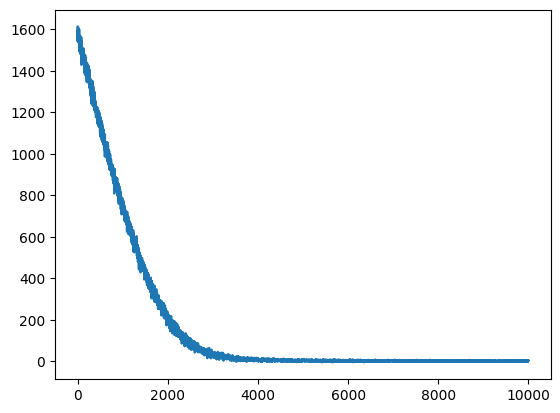

In [23]:
plt.plot(losses)

In [24]:
dict(pyro.get_param_store())

{'inducing_points_locations': tensor([[19.4223, 27.8497, 36.2772, 44.7046, 53.1320, 61.5594, 69.9868, 78.4143,
          86.8417, 95.2691],
         [19.4223, 27.8497, 36.2772, 44.7046, 53.1320, 61.5594, 69.9868, 78.4143,
          86.8417, 95.2691],
         [19.4223, 27.8497, 36.2772, 44.7046, 53.1320, 61.5594, 69.9868, 78.4143,
          86.8417, 95.2691],
         [19.4223, 27.8497, 36.2772, 44.7046, 53.1320, 61.5594, 69.9868, 78.4143,
          86.8417, 95.2691],
         [19.4223, 27.8497, 36.2772, 44.7046, 53.1320, 61.5594, 69.9868, 78.4143,
          86.8417, 95.2691],
         [19.4223, 27.8497, 36.2772, 44.7046, 53.1320, 61.5594, 69.9868, 78.4143,
          86.8417, 95.2691],
         [19.4223, 27.8497, 36.2772, 44.7046, 53.1320, 61.5594, 69.9868, 78.4143,
          86.8417, 95.2691],
         [19.4223, 27.8497, 36.2772, 44.7046, 53.1320, 61.5594, 69.9868, 78.4143,
          86.8417, 95.2691],
         [19.4223, 27.8497, 36.2772, 44.7046, 53.1320, 61.5594, 69.9868, 78.4143,
 